### VGG

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch as th
import torch.nn as nn
from dataset import mnist
from util import (
    get_torch_size_string,
    print_model_parameters,
    print_model_layers,
    model_train,
    model_eval,
    model_test
)
np.set_printoptions(precision=3)
th.set_printoptions(precision=3)
%matplotlib inline
%config InlineBackend.figure_format='retina'
print ("PyTorch version:[%s]."%(th.__version__))

PyTorch version:[2.0.1].


### Hyperparameters

In [2]:
device      = 'cpu' # cpu / mps
n_epoch     = 1
batch_size  = 128
print_every = 1
print ("Ready.")

Ready.


### Dataset

In [3]:
train_iter,test_iter,train_data,train_label,test_data,test_label = \
    mnist(root_path='../data',batch_size=128)
print ("MNIST ready.")

MNIST ready.


### VGG Blocks

In [4]:
def vgg_block(num_convs,out_channels):
    layer_list = []
    for _ in range(num_convs):
        layer_list.append(
            nn.LazyConv2d(
                out_channels = out_channels,
                kernel_size  = 3,
                padding      = 1
            )
        )
        layer_list.append(
            nn.ReLU()
        )
    layer_list.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layer_list)
print ("Ready.")

Ready.


### VGG Nets

In [5]:
class VGG_Class(nn.Module):
    def __init__(
        self,
        name        = 'vgg',
        x_dim       = (1,28,28),
        arch        = ((1,64), (1,128), (2,256), (2,512), (2,512)),
        num_classes = 1000
    ):
        super(VGG_Class,self).__init__()
        self.name        = name
        self.x_dim       = x_dim
        self.arch        = arch
        self.num_classes = num_classes
        
        vgg_block_list = []
        for (num_convs,out_channels) in self.arch:
            vgg_block_list.append(vgg_block(num_convs,out_channels))
        self.net = nn.Sequential(
            *vgg_block_list,
            nn.Flatten(),
            nn.LazyLinear(4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.LazyLinear(4096),
            nn.ReLU(),nn.Dropout(0.5),
            nn.LazyLinear(num_classes)
        )
        self.layer_names = []
        for l_idx,layer in enumerate(self.net):
            layer_name = "%s_%02d"%(type(layer).__name__.lower(),l_idx)
            self.layer_names.append(layer_name)
            
    def init_param(self,VERBOSE=False):
        """
            Initialize parameters
        """
        for m_idx,m in enumerate(self.modules()):
            if VERBOSE:
                print ("[%02d]"%(m_idx))
            if isinstance(m,nn.Conv2d): # init conv
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m,nn.LazyConv2d): # init conv
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m,nn.BatchNorm1d) or isinstance(m,nn.BatchNorm2d): 
                nn.init.constant_(m.weight,1.0)
                nn.init.constant_(m.bias,0.0)
            elif isinstance(m,nn.Linear): # lnit dense
                nn.init.kaiming_normal_(m.weight,nonlinearity='relu')
                nn.init.zeros_(m.bias)
            elif isinstance(m,nn.LazyLinear): # lnit dense
                nn.init.kaiming_normal_(m.weight,nonlinearity='relu')
                nn.init.zeros_(m.bias)
        
    def forward(self,x):
        """
            Forward propagate
        """
        intermediate_output_list = []
        for layer in self.net:
            x = layer(x)
            intermediate_output_list.append(x)
        final_output = x
        return final_output,intermediate_output_list
    
print ("Ready.")        

Ready.


In [6]:
vgg = VGG_Class(
    name        = 'vgg',
    x_dim       = (1,28,28),
    arch        = ((2,64),(2,128),(2,256)), # ((2,64),(2,128),(2,256),(2,512),(2,512)),
    num_classes = 10 # 1000
).to(device)
loss = nn.CrossEntropyLoss()
optm = th.optim.Adam(vgg.parameters(),lr=1e-3)
print ("Ready.")

Ready.


/Users/sj/anaconda3/envs/mujoco/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


### Print model layers

In [7]:
x_torch = th.randn((16,)+vgg.x_dim).to(device)
print_model_layers(vgg,x_torch)

batch_size:[16]
[  ] layer:[          input] size:[    16x1x28x28]
[ 0] layer:[  sequential_00] size:[   16x64x14x14] numel:[    200704]
[ 1] layer:[  sequential_01] size:[    16x128x7x7] numel:[    100352]
[ 2] layer:[  sequential_02] size:[    16x256x3x3] numel:[     36864]
[ 3] layer:[     flatten_03] size:[       16x2304] numel:[     36864]
[ 4] layer:[  lazylinear_04] size:[       16x4096] numel:[     65536]
[ 5] layer:[        relu_05] size:[       16x4096] numel:[     65536]
[ 6] layer:[     dropout_06] size:[       16x4096] numel:[     65536]
[ 7] layer:[  lazylinear_07] size:[       16x4096] numel:[     65536]
[ 8] layer:[        relu_08] size:[       16x4096] numel:[     65536]
[ 9] layer:[     dropout_09] size:[       16x4096] numel:[     65536]
[10] layer:[  lazylinear_10] size:[         16x10] numel:[       160]


### Prinit model parameters

In [8]:
print_model_parameters(vgg)

[ 0] parameter:[             net.0.0.weight] shape:[    64x1x3x3] numel:[       576]
[ 1] parameter:[               net.0.0.bias] shape:[          64] numel:[        64]
[ 2] parameter:[             net.0.2.weight] shape:[   64x64x3x3] numel:[     36864]
[ 3] parameter:[               net.0.2.bias] shape:[          64] numel:[        64]
[ 4] parameter:[             net.1.0.weight] shape:[  128x64x3x3] numel:[     73728]
[ 5] parameter:[               net.1.0.bias] shape:[         128] numel:[       128]
[ 6] parameter:[             net.1.2.weight] shape:[ 128x128x3x3] numel:[    147456]
[ 7] parameter:[               net.1.2.bias] shape:[         128] numel:[       128]
[ 8] parameter:[             net.2.0.weight] shape:[ 256x128x3x3] numel:[    294912]
[ 9] parameter:[               net.2.0.bias] shape:[         256] numel:[       256]
[10] parameter:[             net.2.2.weight] shape:[ 256x256x3x3] numel:[    589824]
[11] parameter:[               net.2.2.bias] shape:[         256]

### Train VGG

In [9]:
model_train(vgg,optm,loss,train_iter,test_iter,n_epoch,print_every,device)

epoch:[ 0/1] loss:[0.234] train_accr:[0.9841] test_accr:[0.9843].


### Test VGG

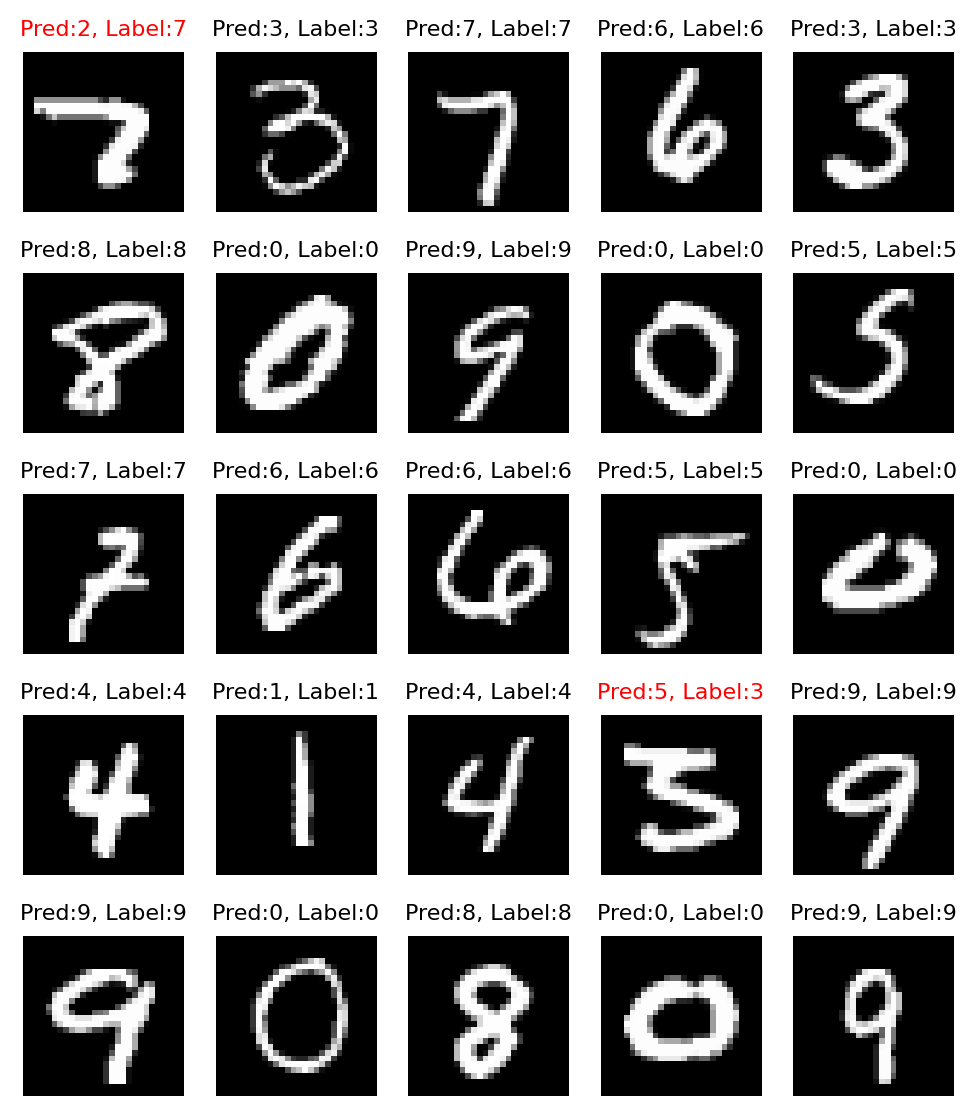

In [10]:
model_test(vgg,test_data,test_label,device)